In [1]:
from utility_programs.read_routines import SAMI

In [2]:
from scipy.spatial import Delaunay
from scipy.interpolate import LinearNDInterpolator, griddata
import numpy as np


from datetime import datetime
from tqdm.auto import tqdm
import xarray as xr

import matplotlib.pyplot as plt

import cartopy.crs as ccrs

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [3]:
import interpolate_outputs

In [4]:
samipath = '/petastore/phil/Prasoon_satellite_project/more_runs/20130317/sami-gitm-coupled/'

In [7]:
import importlib

In [53]:
interpolate_outputs = importlib.reload(interpolate_outputs)

In [54]:
interpolate_outputs.do_interpolations(samipath,
                                    out_path='.',
                                      dtime_sim_start='20130316',
                                    cols='edens',
                                    save_delauney=True,
                                    show_progress=True)

attempting to reuse existing triangulation file


Reading in SAMI data:   0%|          | 0/596 [00:00<?, ?it/s]

  0%|          | 0/597 [00:00<?, ?it/s]

NameError: name 'h5netcdf' is not defined

In [ ]:
ds = xr.open_mfdataset('/petastore/phil/Prasoon_satellite_project/testfiles/SAMI_REGRID')

In [364]:
ds

<xarray.Dataset>
Dimensions:  (time: 597, alt: 20, lat: 180, lon: 90)
Coordinates:
  * time     (time) datetime64[ns] 2011-03-16 ... 2011-03-18T01:39:54
  * alt      (alt) int64 200 300 400 500 600 700 ... 1700 1800 1900 2000 2100
  * lat      (lat) int64 -90 -89 -88 -87 -86 -85 -84 ... 83 84 85 86 87 88 89
  * lon      (lon) int64 0 4 8 12 16 20 24 28 ... 332 336 340 344 348 352 356
Data variables:
    edens    (time, lat, lon, alt) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0

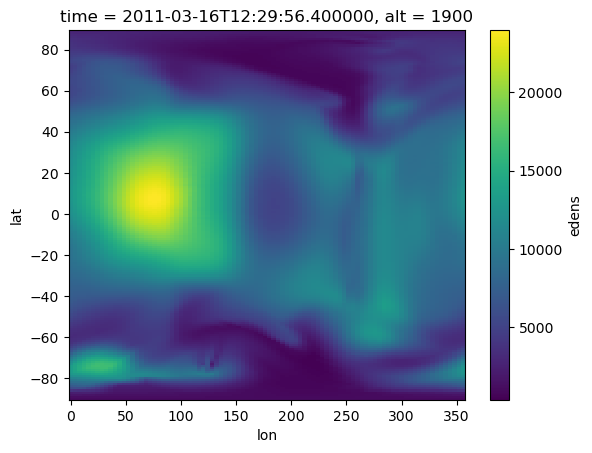

In [367]:
ds.edens.isel(time=150, alt=17).plot(x='lon')

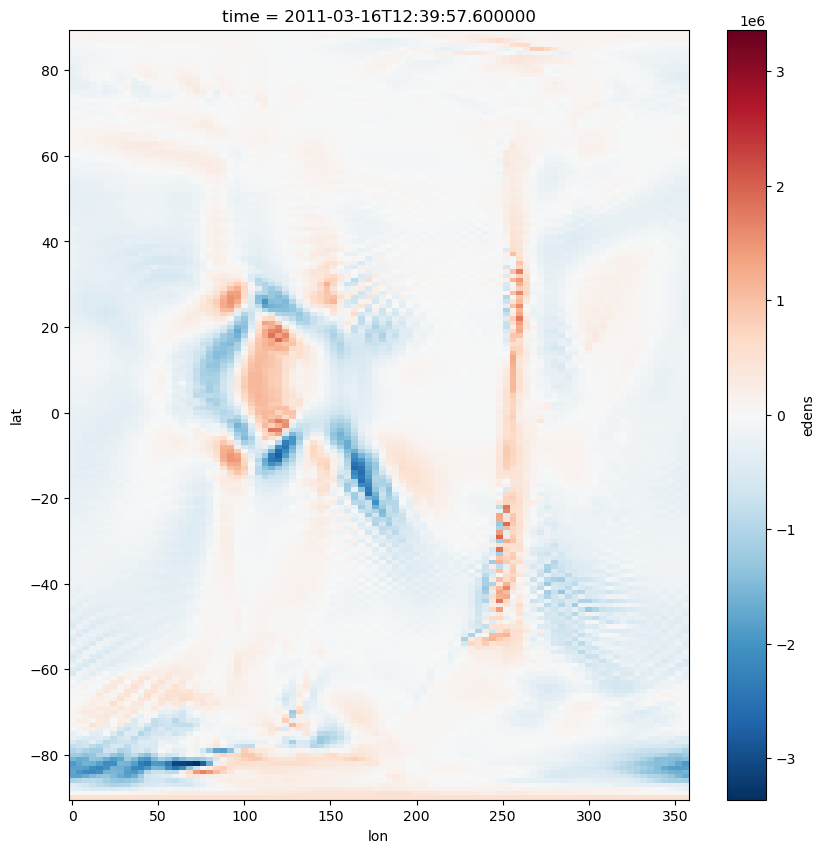

In [373]:
plt.figure(figsize=(10,10))
ds.edens.integrate('alt').diff('time', 2).isel(time=150).plot(x='lon')
plt.show()